 # 🍄 Mushroom Classification Project



 ## Project Overview



 Building a machine learning model to help prevent mushroom poisoning incidents through accurate species identification.



 **Key Facts:**



 - ~7,500 yearly mushroom poisoning cases in the US

 - Main cause: misidentification of edible species

 - Goal: Create model to assist in safe mushroom identification

 ## 1. Setup and Imports

In [1]:
import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet34_Weights
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from config import Config
from mushroom_dataset import MushroomDataset
from mushroom_data_module import MushroomDataModule

import multiprocessing


c:\Users\kresi\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 ## 3. Data Transforms

Training transforms include:
- Resizing images to consistent dimensions
- Various augmentations (flips, rotations, brightness/contrast adjustments)
- Color transformations
- Random cropping
- Normalization using ImageNet statistics
- Conversion to PyTorch tensors

Validation transforms are simpler:
- Only resize and normalize (no augmentation needed for validation)

In [2]:
train_transforms = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RandomResizedCrop(Config.IMG_SIZE, Config.IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


INFO:mushroom_data_module:DataModule initialized with batch_size: 32, workers: 4


 ## 6. Model

The MushroomClassifier class defines the neural network:
- Uses ResNet34 as the backbone with pretrained weights
- Implements fine-tuning strategy:
  - Freezes early layers (transfer learning)
  - Only trains last two layers and classifier
- Includes custom training and validation steps
- Uses weighted loss function to handle class imbalance
- Implements accuracy metrics for both training and validation
- Uses AdamW optimizer with weight decay
- Implements learning rate scheduling with ReduceLROnPlateau

In [ ]:
class MushroomClassifier(pl.LightningModule):
    def __init__(self, num_classes=9, learning_rate=1e-4, class_weights=None):
        super().__init__()

        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.class_weights = class_weights

        self.model = models.resnet34(weights=ResNet34_Weights.DEFAULT)

        for name, param in self.model.named_parameters():
            if "layer3" in name or "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, self.num_classes)

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
        loss = loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.train_acc(preds, y)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # Use class weights in loss function
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
        loss = loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.val_acc(preds, y)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            (p for p in self.parameters() if p.requires_grad),
            lr=self.learning_rate,
            weight_decay=0.01
        )

        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=2,
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }


 ## 7. Training Setup and Execution

The train_model function handles the training pipeline:
- Initializes model with class weights
- Sets up GPU acceleration if available
- Implements callbacks:
  - ModelCheckpoint to save best models
  - EarlyStopping to prevent overfitting
- Configures PyTorch Lightning trainer with:
  - Mixed precision training when possible
  - Progress bar
  - Specified number of epochs

In [ ]:
def train_model(data_module):
    logger.info("Initializing training process...")

    data_module.setup()

    logger.info("Creating model...")
    model = MushroomClassifier(class_weights=data_module.class_weights)

    logger.info("Setting up trainer...")
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
    devices = 1 if accelerator == 'gpu' else None
    precision = '16-mixed' if accelerator == 'gpu' else 32

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='mushroom-classifier-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=Config.EARLY_STOPPING_PATIENCE,
        mode='min',
        verbose=True
    )

    trainer = pl.Trainer(
        max_epochs=Config.EPOCHS,
        accelerator=accelerator,
        devices=devices,
        precision=precision,
        enable_progress_bar=True,
        callbacks=[
            checkpoint_callback,
            early_stopping_callback
        ]
    )

    logger.info("Starting training...")
    trainer.fit(model, data_module)

    return model, trainer


 ## 8. Run Training

The main execution block:
- Sets up multiprocessing for data loading
- Ensures reproducibility with random seeds
- Configures device (GPU/CPU)
- Creates data module with specified transforms
- Executes the training process

In [5]:
if __name__ == "__main__":
    multiprocessing.set_start_method('spawn', force=True)

    pl.seed_everything(42)
    Config.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_module = MushroomDataModule(
        Config.DATA_PATH,
        batch_size=Config.BATCH_SIZE,
        num_workers=4,
        train_transforms=train_transforms,
        val_transforms=val_transforms
    )

    model, trainer = train_model(data_module)


Seed set to 42
INFO:mushroom_data_module:DataModule initialized with batch_size: 32, workers: 4
INFO:__main__:Initializing training process...
INFO:mushroom_data_module:Setting up DataModule for stage: None
INFO:mushroom_data_module:Processing genus Agaricus (class 0)
INFO:mushroom_data_module:Processing genus Amanita (class 1)
INFO:mushroom_data_module:Processing genus Boletus (class 2)
INFO:mushroom_data_module:Processing genus Cortinarius (class 3)
INFO:mushroom_data_module:Processing genus Entoloma (class 4)
INFO:mushroom_data_module:Processing genus Hygrocybe (class 5)
INFO:mushroom_data_module:Processing genus Lactarius (class 6)
INFO:mushroom_data_module:Processing genus Russula (class 7)
INFO:mushroom_data_module:Processing genus Suillus (class 8)
INFO:mushroom_data_module:Train dataset size: 5371
INFO:mushroom_data_module:Val dataset size: 1343
INFO:__main__:Creating model...
INFO:__main__:Setting up trainer...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.702


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.611


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.583


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.497


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.446


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.393


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.381


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.381. Signaling Trainer to stop.


 ## 9. Model Evaluation

The evaluation code:
- Runs predictions on validation set
- Creates and plots confusion matrix
- Generates detailed classification report
- Handles moving data between CPU and GPU
- Visualizes results using seaborn heatmap

In [6]:

def evaluate_model(model, data_module):
    model.eval()

    model = model.to(Config.DEVICE)

    val_loader = data_module.val_dataloader()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x = x.to(Config.DEVICE)
            y = y.to(Config.DEVICE)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_module.class_to_idx.keys(), yticklabels=data_module.class_to_idx.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=list(data_module.class_to_idx.keys())
    ))


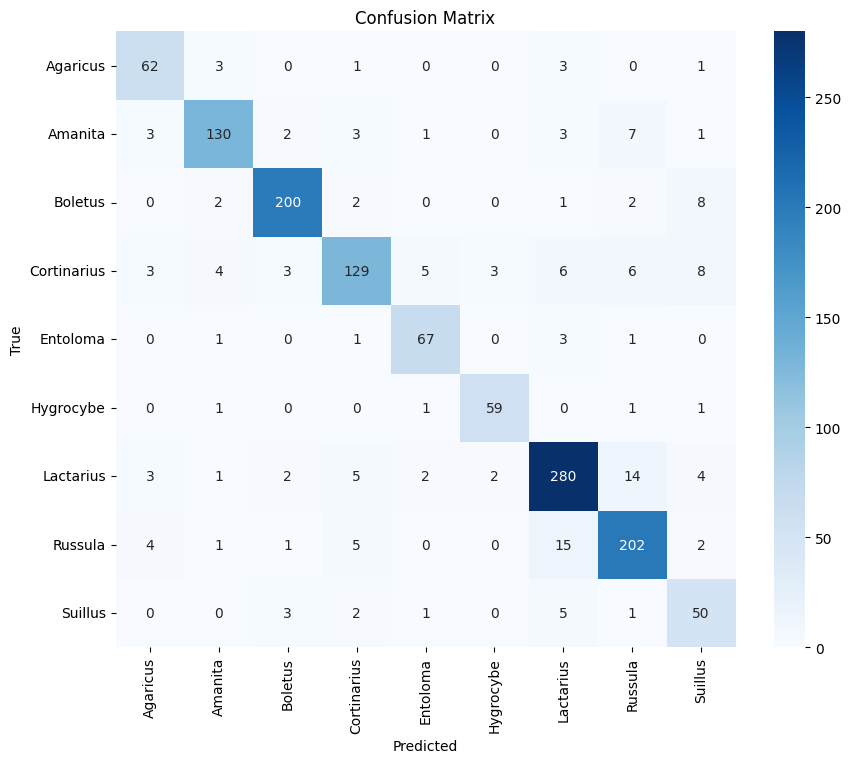


Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.83      0.89      0.86        70
     Amanita       0.91      0.87      0.89       150
     Boletus       0.95      0.93      0.94       215
 Cortinarius       0.87      0.77      0.82       167
    Entoloma       0.87      0.92      0.89        73
   Hygrocybe       0.92      0.94      0.93        63
   Lactarius       0.89      0.89      0.89       313
     Russula       0.86      0.88      0.87       230
     Suillus       0.67      0.81      0.73        62

    accuracy                           0.88      1343
   macro avg       0.86      0.88      0.87      1343
weighted avg       0.88      0.88      0.88      1343



In [7]:
if __name__ == "__main__":
    evaluate_model(model, data_module)


Based on the confusion matrix and classification report, here are the key conclusions for the mushroom classification model:

Strong Performance Points:
1. Overall Accuracy: The model achieves a solid 88% accuracy across all classes, which is quite good for a 9-class mushroom classification problem.

2. Best Performing Classes:
- Boletus: Excellent performance with 0.94 F1-score (95% precision, 93% recall)
- Hygrocybe: Very strong with 0.93 F1-score (92% precision, 94% recall)
- Most classes show F1-scores between 0.86-0.89, indicating consistent performance

Areas for Improvement:
1. Suillus Class:
- Lowest performing class with 0.73 F1-score
- Lower precision (67%) suggests more false positives
- Often confused with Boletus (8 cases) and Lactarius (5 cases)

2. Cortinarius:
- Lower recall (77%) indicates more missed identifications
- Shows confusion with several other species, particularly Lactarius and Russula

Common Confusion Patterns:
1. Lactarius-Russula Confusion:
- 14 Lactarius specimens misclassified as Russula
- 15 Russula specimens misclassified as Lactarius
- This is understandable as these genera share similar morphological features

Safety Implications:
1. The model shows good precision for potentially dangerous genera like Amanita (91% precision), which is crucial for safety.
2. Most misclassifications occur between similar-looking, related genera rather than between edible and poisonous species.

Recommendations:
1. To improve Suillus classification:
- Collect more training data for this class
- Consider additional augmentation techniques specific to Suillus features
- Review the misclassified cases to identify common patterns

2. For Cortinarius improvement:
- Focus on distinctive features that separate it from Lactarius and Russula
- Possibly implement attention mechanisms to focus on key distinguishing characteristics

3. General improvements:
- Consider implementing confidence thresholds for classifications
- Add explanatory features to highlight what the model is looking at
- Implement ensemble methods for critical classifications

The model appears suitable for initial screening but should be used as part of a broader identification process, especially given the safety-critical nature of mushroom identification.